# Day 5: Volatility Modeling (ARCH/GARCH)
## Week 3: Time Series Analysis for Finance

---

**Learning Objectives:**
- Understand volatility clustering
- Implement ARCH and GARCH models
- Forecast volatility
- Apply to risk management

In [1]:
# pip install arch

In [2]:
# Day 5 Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from arch import arch_model
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')

# Load data
df = pd.read_csv('../datasets/raw_data/combined_adjusted_close.csv', 
                 index_col='Date', parse_dates=True)
prices = df[['AAPL', 'MSFT', 'SPY', 'JPM']].dropna()
returns = prices.pct_change().dropna() * 100  # Percentage returns

print("=" * 60)
print("VOLATILITY MODELING (ARCH/GARCH) - DAY 5")
print("=" * 60)

VOLATILITY MODELING (ARCH/GARCH) - DAY 5


## 1. Volatility Clustering

**Key Observation:** Large returns tend to be followed by large returns (of either sign).

This means:
- Volatility is **not constant** over time
- Returns may be uncorrelated, but squared returns are correlated
- Standard time series models miss this!

EVIDENCE OF VOLATILITY CLUSTERING


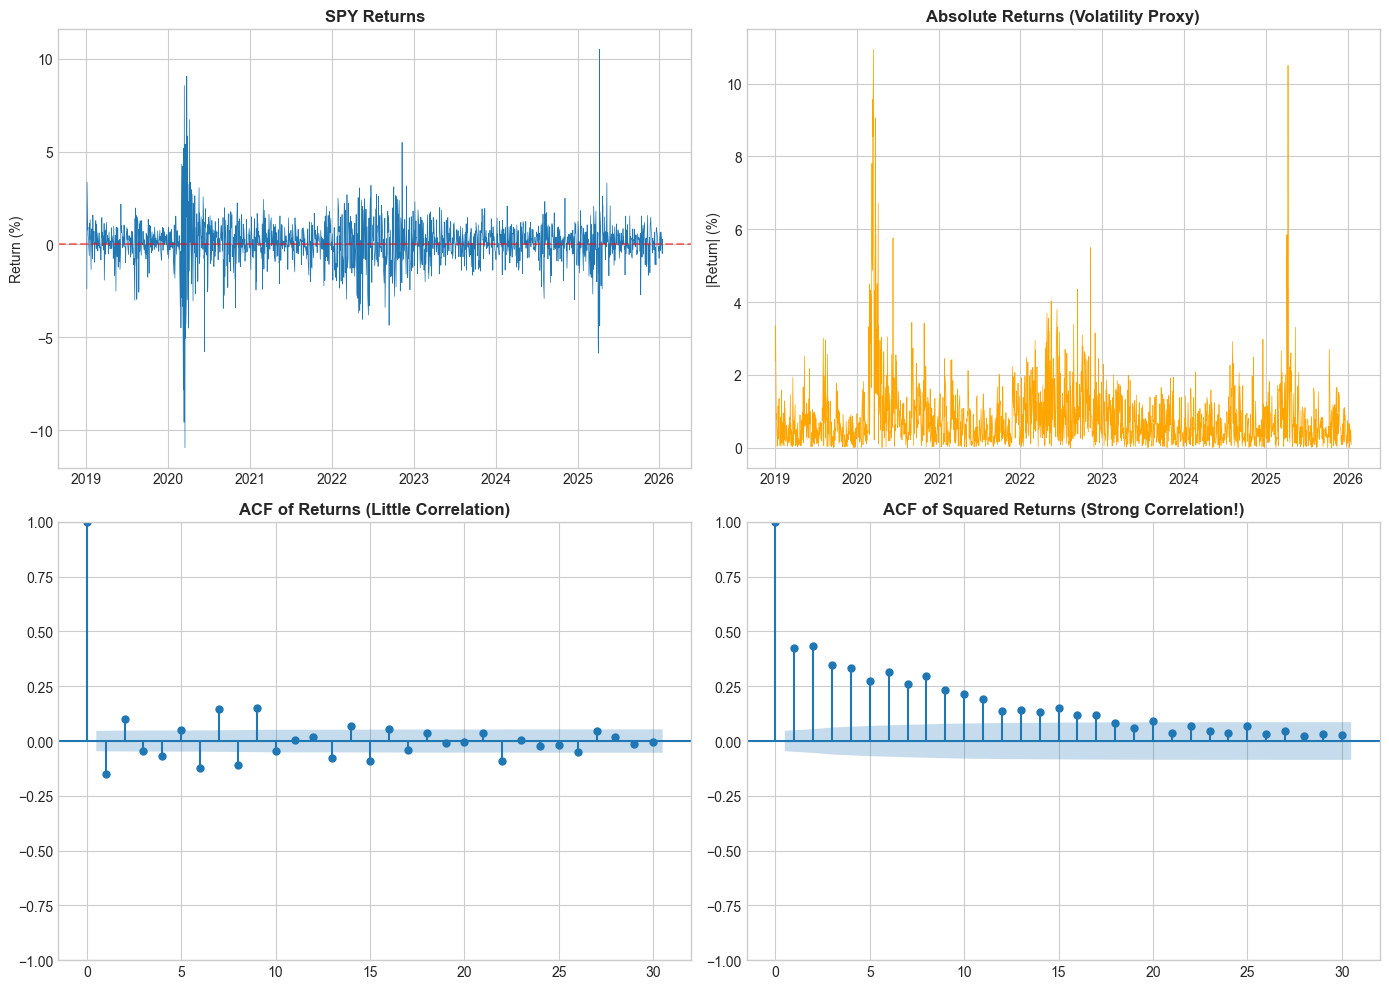


Ljung-Box Test Results (lag 10):
  Returns:         p = 0.0000 → Correlated
  Squared Returns: p = 0.000000 → Correlated

💡 Key Insight: Returns look random, but their volatility is predictable!


In [3]:
# Demonstrate volatility clustering
print("=" * 60)
print("EVIDENCE OF VOLATILITY CLUSTERING")
print("=" * 60)

spy_ret = returns['SPY']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Returns
axes[0,0].plot(spy_ret, lw=0.5)
axes[0,0].axhline(0, color='red', linestyle='--', alpha=0.5)
axes[0,0].set_title('SPY Returns', fontweight='bold')
axes[0,0].set_ylabel('Return (%)')

# Absolute returns (proxy for volatility)
axes[0,1].plot(spy_ret.abs(), lw=0.5, color='orange')
axes[0,1].set_title('Absolute Returns (Volatility Proxy)', fontweight='bold')
axes[0,1].set_ylabel('|Return| (%)')

# ACF of returns vs squared returns
plot_acf(spy_ret.dropna(), lags=30, ax=axes[1,0], alpha=0.05)
axes[1,0].set_title('ACF of Returns (Little Correlation)', fontweight='bold')

plot_acf(spy_ret.dropna()**2, lags=30, ax=axes[1,1], alpha=0.05)
axes[1,1].set_title('ACF of Squared Returns (Strong Correlation!)', fontweight='bold')

plt.tight_layout()
plt.show()

# Ljung-Box tests
lb_ret = acorr_ljungbox(spy_ret.dropna(), lags=[10], return_df=True)
lb_sq = acorr_ljungbox(spy_ret.dropna()**2, lags=[10], return_df=True)

print("\nLjung-Box Test Results (lag 10):")
print(f"  Returns:         p = {lb_ret['lb_pvalue'].values[0]:.4f} → {'White noise' if lb_ret['lb_pvalue'].values[0] > 0.05 else 'Correlated'}")
print(f"  Squared Returns: p = {lb_sq['lb_pvalue'].values[0]:.6f} → {'White noise' if lb_sq['lb_pvalue'].values[0] > 0.05 else 'Correlated'}")

print("\n💡 Key Insight: Returns look random, but their volatility is predictable!")

## 2. ARCH Model

**ARCH(q)** - AutoRegressive Conditional Heteroskedasticity:

$$r_t = \mu + \epsilon_t$$
$$\epsilon_t = \sigma_t z_t, \quad z_t \sim N(0,1)$$
$$\sigma_t^2 = \omega + \sum_{i=1}^{q} \alpha_i \epsilon_{t-i}^2$$

Variance depends on past squared errors!

In [4]:
# ARCH Model
print("=" * 60)
print("ARCH(1) MODEL")
print("=" * 60)

# Fit ARCH(1)
arch1 = arch_model(spy_ret.dropna(), vol='ARCH', p=1, mean='Constant')
arch1_fit = arch1.fit(disp='off')

print(arch1_fit.summary())

ARCH(1) MODEL
                      Constant Mean - ARCH Model Results                      
Dep. Variable:                    SPY   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -2660.27
Distribution:                  Normal   AIC:                           5326.54
Method:            Maximum Likelihood   BIC:                           5342.97
                                        No. Observations:                 1770
Date:                Tue, Jan 20 2026   Df Residuals:                     1769
Time:                        23:42:22   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1423  2.913e-02      4.886  1.031

## 3. GARCH Model

**GARCH(p,q)** - Generalized ARCH:

$$\sigma_t^2 = \omega + \sum_{i=1}^{q} \alpha_i \epsilon_{t-i}^2 + \sum_{j=1}^{p} \beta_j \sigma_{t-j}^2$$

- More parsimonious than high-order ARCH
- GARCH(1,1) is the workhorse model
- α + β < 1 required for stationarity

In [5]:
# GARCH(1,1) Model
print("=" * 60)
print("GARCH(1,1) MODEL")
print("=" * 60)

# Fit GARCH(1,1)
garch11 = arch_model(spy_ret.dropna(), vol='GARCH', p=1, q=1, mean='Constant')
garch11_fit = garch11.fit(disp='off')

print(garch11_fit.summary())

# Extract key parameters
omega = garch11_fit.params['omega']
alpha = garch11_fit.params['alpha[1]']
beta = garch11_fit.params['beta[1]']

print("\n" + "=" * 40)
print("KEY PARAMETERS:")
print(f"  ω (omega):  {omega:.6f}")
print(f"  α (alpha):  {alpha:.4f}")
print(f"  β (beta):   {beta:.4f}")
print(f"  α + β:      {alpha + beta:.4f}")
print(f"\n  Persistence = α + β = {alpha + beta:.4f}")
print(f"  (Closer to 1 = more persistent volatility)")

# Unconditional variance
uncond_var = omega / (1 - alpha - beta)
uncond_vol = np.sqrt(uncond_var)
print(f"\n  Unconditional Vol (daily): {uncond_vol:.4f}%")
print(f"  Unconditional Vol (annual): {uncond_vol * np.sqrt(252):.2f}%")

GARCH(1,1) MODEL
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                    SPY   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2447.86
Distribution:                  Normal   AIC:                           4903.71
Method:            Maximum Likelihood   BIC:                           4925.63
                                        No. Observations:                 1770
Date:                Tue, Jan 20 2026   Df Residuals:                     1769
Time:                        23:42:22   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1037  1.936e-02      5.357  8.

CONDITIONAL VOLATILITY


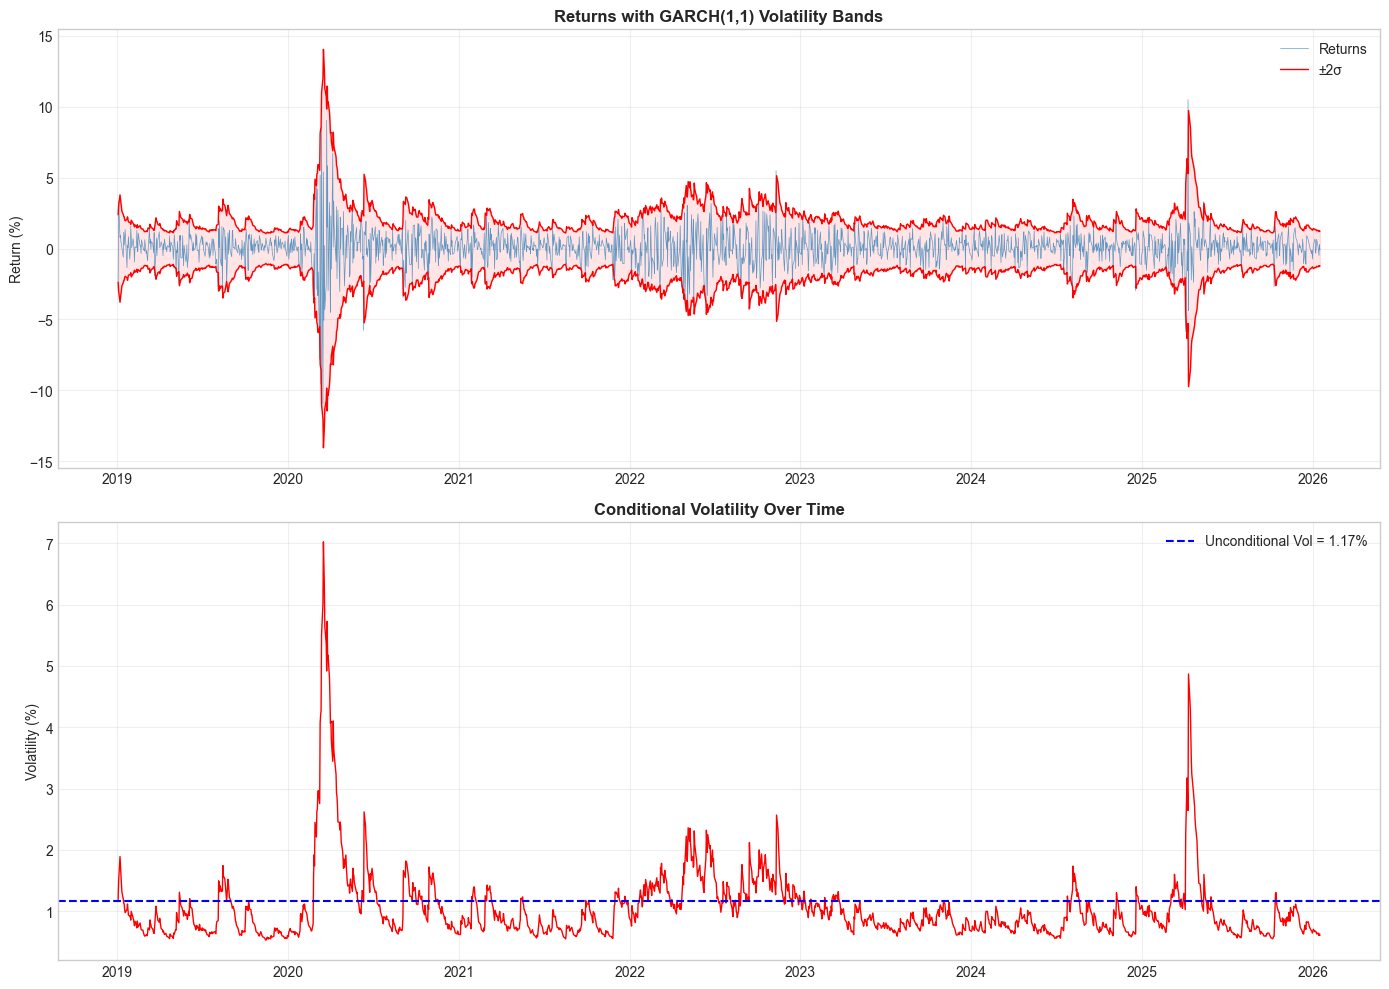

In [6]:
# Visualize conditional volatility
print("=" * 60)
print("CONDITIONAL VOLATILITY")
print("=" * 60)

cond_vol = garch11_fit.conditional_volatility

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Returns with volatility bands
axes[0].plot(spy_ret, lw=0.5, alpha=0.7, label='Returns')
axes[0].plot(cond_vol.index, 2*cond_vol, 'r-', lw=1, label='±2σ')
axes[0].plot(cond_vol.index, -2*cond_vol, 'r-', lw=1)
axes[0].fill_between(cond_vol.index, 2*cond_vol, -2*cond_vol, alpha=0.1, color='red')
axes[0].set_title('Returns with GARCH(1,1) Volatility Bands', fontweight='bold')
axes[0].set_ylabel('Return (%)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Conditional volatility over time
axes[1].plot(cond_vol, lw=1, color='red')
axes[1].axhline(uncond_vol, color='blue', linestyle='--', label=f'Unconditional Vol = {uncond_vol:.2f}%')
axes[1].set_title('Conditional Volatility Over Time', fontweight='bold')
axes[1].set_ylabel('Volatility (%)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Model Comparison

In [7]:
# Compare different GARCH models
print("=" * 60)
print("MODEL COMPARISON")
print("=" * 60)

models = {
    'ARCH(1)': arch_model(spy_ret.dropna(), vol='ARCH', p=1),
    'ARCH(5)': arch_model(spy_ret.dropna(), vol='ARCH', p=5),
    'GARCH(1,1)': arch_model(spy_ret.dropna(), vol='GARCH', p=1, q=1),
    'GARCH(2,1)': arch_model(spy_ret.dropna(), vol='GARCH', p=2, q=1),
    'GARCH(1,2)': arch_model(spy_ret.dropna(), vol='GARCH', p=1, q=2),
}

results = []
for name, model in models.items():
    fit = model.fit(disp='off')
    results.append({
        'Model': name,
        'AIC': fit.aic,
        'BIC': fit.bic,
        'Log-Lik': fit.loglikelihood
    })

results_df = pd.DataFrame(results).sort_values('AIC')
print("\nModel Comparison (sorted by AIC):")
print(results_df.to_string(index=False))

print(f"\n✅ Best Model: {results_df.iloc[0]['Model']}")

MODEL COMPARISON

Model Comparison (sorted by AIC):
     Model         AIC         BIC      Log-Lik
GARCH(1,1) 4903.711843 4925.626782 -2447.855922
GARCH(2,1) 4904.411918 4931.805593 -2447.205959
GARCH(1,2) 4905.711842 4933.105517 -2447.855921
   ARCH(5) 4938.297124 4976.648267 -2462.148562
   ARCH(1) 5326.537002 5342.973207 -2660.268501

✅ Best Model: GARCH(1,1)


## 5. Volatility Forecasting

VOLATILITY FORECASTING


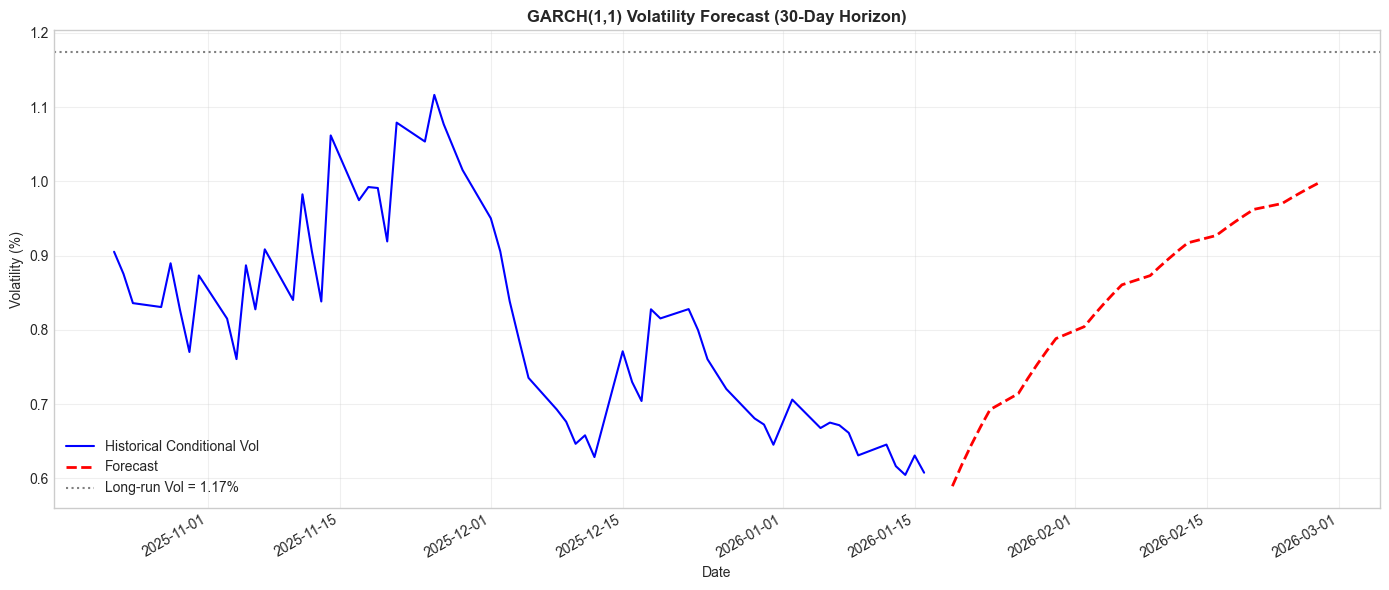


Volatility Forecast:
  Current:      0.61%
  1-day ahead:  0.59%
  5-day ahead:  0.69%
  30-day ahead: 1.00%

💡 Volatility forecast converges to unconditional level over time


In [8]:
# Volatility forecasting
print("=" * 60)
print("VOLATILITY FORECASTING")
print("=" * 60)

# Forecast volatility
horizon = 30  # 30 days ahead
forecast = garch11_fit.forecast(horizon=horizon)

# Extract variance forecast
var_forecast = forecast.variance.iloc[-1]
vol_forecast = np.sqrt(var_forecast)

# Visualize
fig, ax = plt.subplots(figsize=(14, 6))

# Historical volatility
cond_vol[-60:].plot(ax=ax, label='Historical Conditional Vol', color='blue', lw=1.5)

# Forecast
forecast_dates = pd.date_range(start=cond_vol.index[-1] + pd.Timedelta(days=1), 
                                periods=horizon, freq='B')
ax.plot(forecast_dates, vol_forecast.values, 'r--', lw=2, label='Forecast')
ax.axhline(uncond_vol, color='gray', linestyle=':', label=f'Long-run Vol = {uncond_vol:.2f}%')

ax.set_title(f'GARCH(1,1) Volatility Forecast ({horizon}-Day Horizon)', fontweight='bold')
ax.set_ylabel('Volatility (%)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nVolatility Forecast:")
print(f"  Current:      {cond_vol.iloc[-1]:.2f}%")
print(f"  1-day ahead:  {vol_forecast.iloc[0]:.2f}%")
print(f"  5-day ahead:  {vol_forecast.iloc[4]:.2f}%")
print(f"  30-day ahead: {vol_forecast.iloc[-1]:.2f}%")
print(f"\n💡 Volatility forecast converges to unconditional level over time")

In [9]:
# VaR calculation using GARCH
print("=" * 60)
print("VALUE-AT-RISK (VaR) WITH GARCH")
print("=" * 60)

# 1-day 95% and 99% VaR using GARCH volatility
current_vol = cond_vol.iloc[-1]
mean_return = garch11_fit.params['mu']

# VaR = μ - z * σ
var_95 = mean_return - 1.645 * current_vol
var_99 = mean_return - 2.326 * current_vol

print(f"\n1-Day VaR (using current GARCH volatility):")
print(f"  Current Daily Vol: {current_vol:.2f}%")
print(f"  95% VaR: {var_95:.2f}%")
print(f"  99% VaR: {var_99:.2f}%")

# Compare with historical VaR
hist_var_95 = spy_ret.quantile(0.05)
hist_var_99 = spy_ret.quantile(0.01)

print(f"\nHistorical VaR (unconditional):")
print(f"  95% VaR: {hist_var_95:.2f}%")
print(f"  99% VaR: {hist_var_99:.2f}%")

print("\n💡 GARCH VaR adapts to current market conditions!")

VALUE-AT-RISK (VaR) WITH GARCH

1-Day VaR (using current GARCH volatility):
  Current Daily Vol: 0.61%
  95% VaR: -0.90%
  99% VaR: -1.31%

Historical VaR (unconditional):
  95% VaR: -1.76%
  99% VaR: -3.43%

💡 GARCH VaR adapts to current market conditions!


## 📝 Key Takeaways - Day 5

### Volatility Clustering:
- Returns are unpredictable, but volatility is predictable
- Squared returns show strong autocorrelation
- ARCH/GARCH capture this pattern

### GARCH(1,1) Model:
$$\sigma_t^2 = \omega + \alpha \epsilon_{t-1}^2 + \beta \sigma_{t-1}^2$$

- ω: Long-run variance component
- α: Reaction to recent shocks
- β: Persistence of volatility
- α + β: Total persistence (< 1 for stability)

### Applications:
- Dynamic VaR/risk management
- Option pricing
- Portfolio optimization
- Volatility trading

### Interview Questions:
- "Explain volatility clustering"
- "What's the difference between ARCH and GARCH?"
- "How would you use GARCH for VaR?"
- "What does α + β close to 1 mean?"